## Data Exploration
Datasets: S&P500 (USA), Dow Jones (USA), Nasdaq (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), 
BSESN (India), DAX (Europe), SMI (Switzerland), MXX (Mexico), BVSP (Brazil)
1. Find least correlated datasets
2. Distribution of prices, daily returns, drawdowns
3. Identification/Definition of crashes

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import seaborn as sns
from pylab import rcParams
from collections import defaultdict
from scipy.optimize import curve_fit
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

#### 1. Find least correlated datasets

Correlations of returns between datasets:


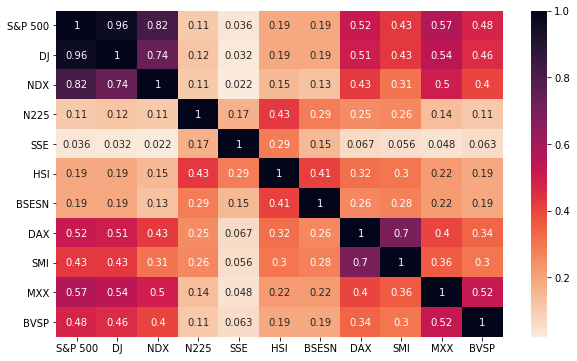

In [55]:
os.chdir('/home/roman/Documents/Projects/Bubbles/data')
datasets_original_test = ['^GSPC.csv', '^DJI.csv', '^NDX.csv', '^N225.csv', 'SSE.csv',\
                     '^HSI.csv', '^BSESN.csv', '^GDAXI.csv', '^SSMI.csv', '^MXX.csv', \
                     '^BVSP.csv']
dataset_names_test = ['S&P 500', 'DJ', 'NDX', 'N225', 'SSE', 'HSI', 'BSESN', 'DAX', \
                 'SMI', 'MXX', 'BVSP']
datasets_test = []
for d in datasets_original_test:
    data_original = pd.read_csv(d, index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
    data_ch = data_original['Close'].pct_change()
    datasets_test.append(data_ch)
df_returns = pd.concat(datasets_test, axis=1, join_axes=[datasets_test[0].index])
df_returns.columns = dataset_names_test
corr = df_returns.corr()
print('Correlations of daily returns between datasets:')
ax = sns.heatmap(corr, annot=True, cmap='rocket_r')

The Correlation matrix shows that the three US indices, the DAX and SMI and the MXX and BVSP are highly correlated. To avoid overfitting when training prediction models, a correlation of > 0.5 for any two datasets should be avoided. Therefore, the SJ, NDX, DAX and MXX will be excluded for further analysis

Correlations of returns between datasets (non-correlated datasets):


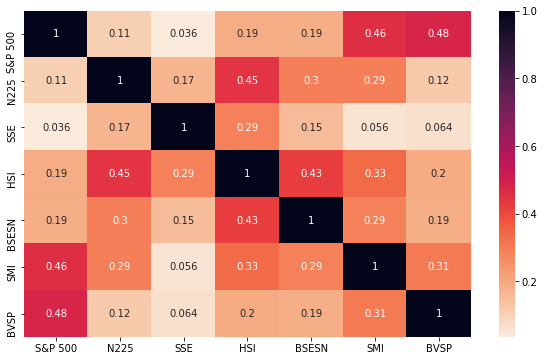

In [57]:
datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv', \
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']
datasets = []
for d in datasets_original:
    data_original = pd.read_csv(d, index_col = 'Date')
    data_original.index = pd.to_datetime(data_original.index, format='%Y/%m/%d')
    data_norm = data_original['Close'] / data_original['Close'][-1]
    data_ch = data_original['Close'].pct_change()
    window = 10
    data_vol = data_original['Close'].pct_change().rolling(window).std()
    data = pd.concat([data_original['Close'], data_norm, data_ch, data_vol], axis=1).dropna()
    data.columns = ['price', 'norm', 'ch', 'vol']
    datasets.append(data)
datasets[5] = datasets[5].loc['1990-11-09':,:]  #<-- SMI has much missing data before 11/9/90

df_ch = [d['ch'] for d in datasets]
df_returns = pd.concat(df_ch, axis=1, join_axes=[datasets[0].index])
df_returns.columns = dataset_names
corr = df_returns.corr()
print('Correlations of daily returns between datasets (non-correlated datasets):')
ax = sns.heatmap(corr, annot=True, cmap='rocket_r')

The correlation matrix with the remaining datasets shows no correlations among any two datasets of > 0.5

#### 2. Distribution of prices, daily returns, drawdowns

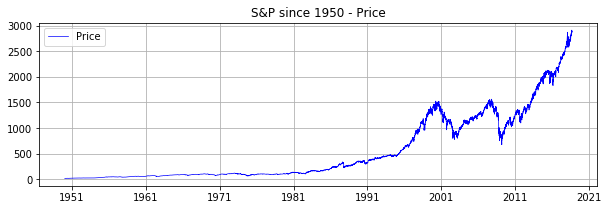

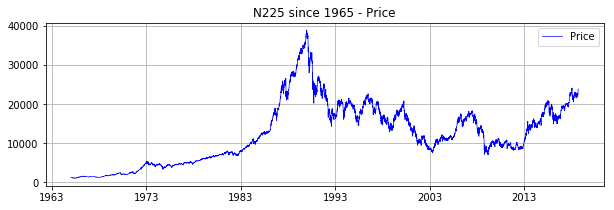

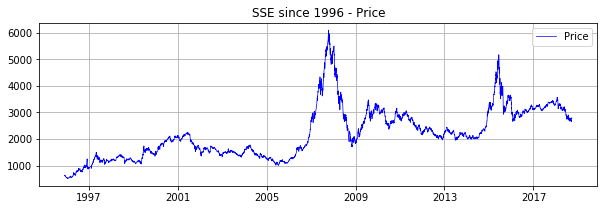

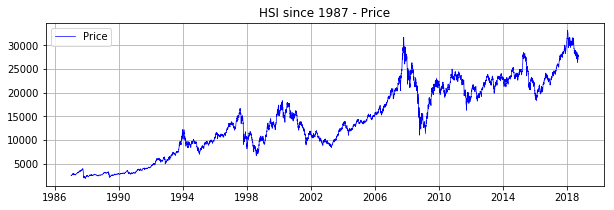

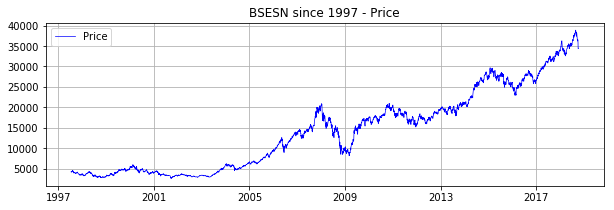

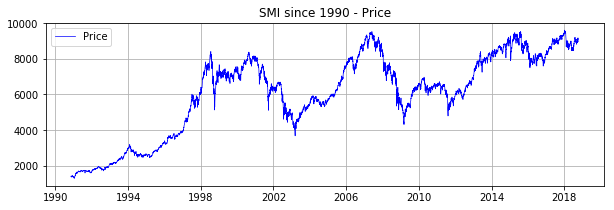

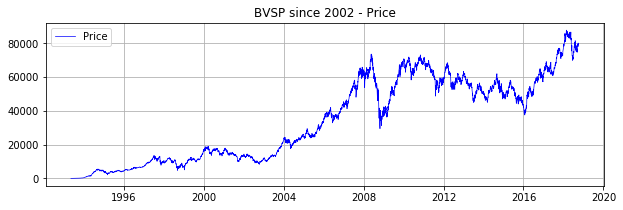

In [60]:
##### Plot price over time
rcParams['figure.figsize'] = 10, 3
plt_titles = ['S&P since 1950', 'N225 since 1965', 'SSE since 1996', 'HSI since 1987', \
              'BSESN since 1997', 'SMI since 1990', 'BVSP since 2002']
for ds, t in zip(datasets, plt_titles):
    plt.plot(ds['price'], color='blue', linewidth=0.7)
    plt.grid()
    plt.legend(['Price'])
    plt.title(t + ' - Price')
    plt.show()

The time series plots give an impression of the performance of the different markets over the past 50-20 years.

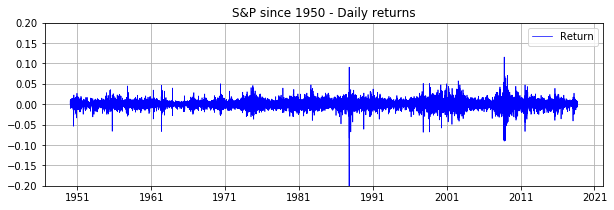

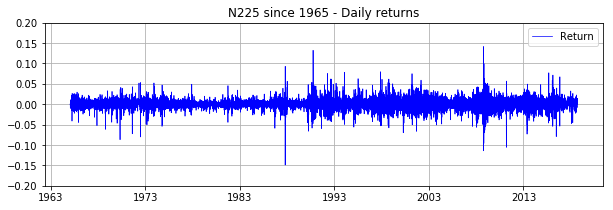

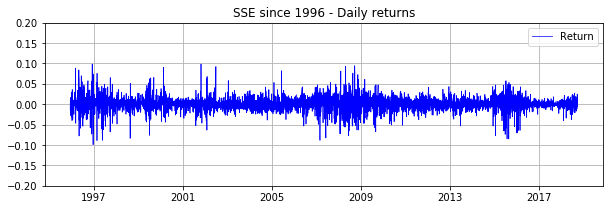

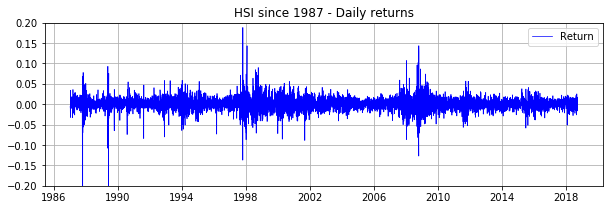

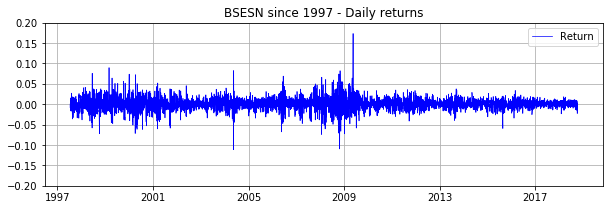

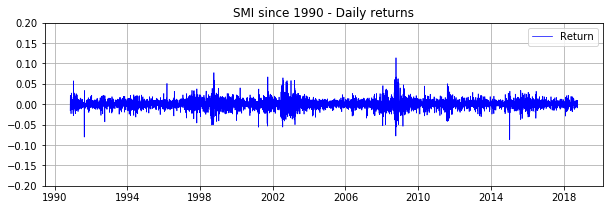

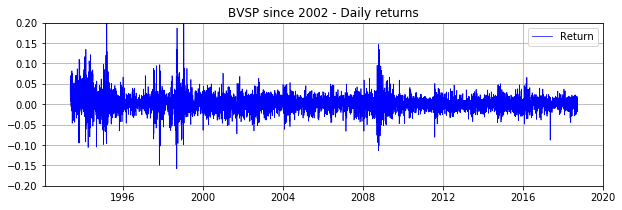

In [63]:
##### Plot daily return over time
for ds, t in zip(datasets, plt_titles):
    plt.plot(ds['ch'], color='blue', linewidth=0.7)
    plt.ylim(-0.2, 0.2)
    plt.grid()
    plt.legend(['Return'])
    plt.title(t + ' - Daily returns')
    plt.show()

The amplitude of daily returns over time for all datasets give an impression of the volatility in the different markets with the Brazilian market showing the larges daily gains/losses.

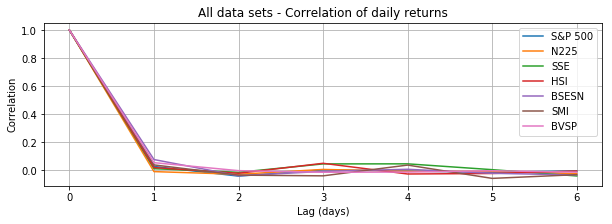

In [65]:
##### Autocorrelation
corr_ds = []
for ds, t in zip(datasets, plt_titles):
    corr = [1]
    for i in range(1, 7):
        corr.append(np.corrcoef(ds['ch'][i:], ds['ch'][:-i])[0, 1])
    plt.plot(corr)
plt.title('All data sets - Correlation of daily returns')
plt.legend(dataset_names)
plt.xlabel('Lag (days)')
plt.ylabel('Correlation')
plt.grid()
plt.show()

The autocorrelation of daily returns is close to zero for a lag > 1 day, indicating that the daily return is not a strong predictor for the price change of the following day.

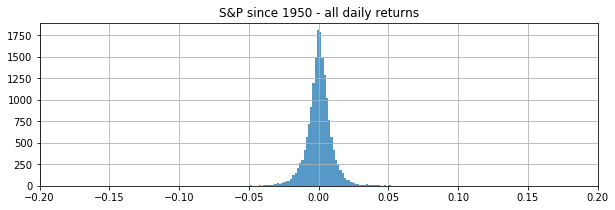

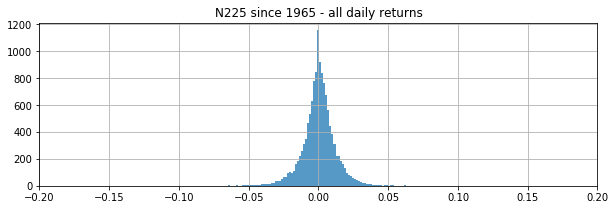

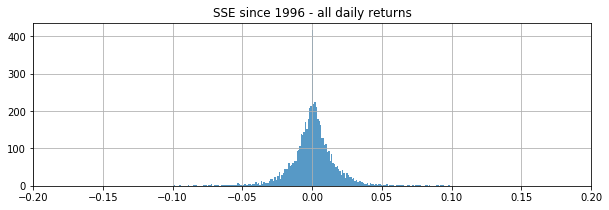

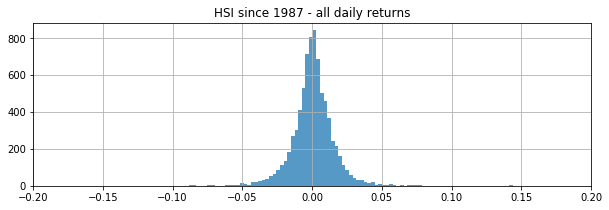

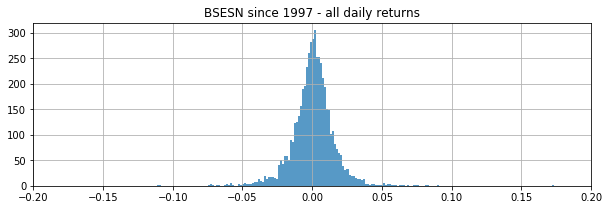

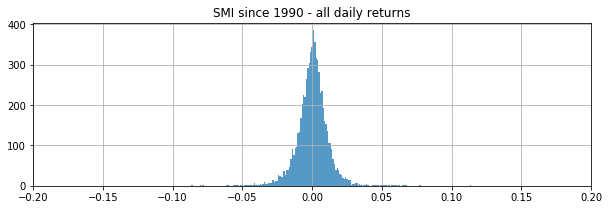

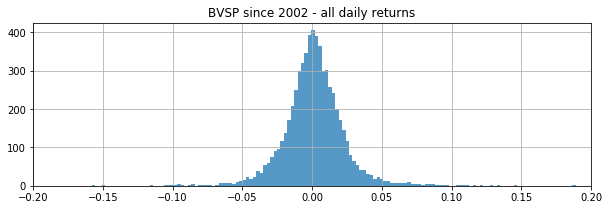

In [66]:
# Plot distribution of daily returns
for ds, t in zip(datasets, plt_titles):
    plt.hist(ds['ch'], bins=200, rwidth=1, alpha=0.75)
    plt.xlim(-0.2, 0.2)
    plt.title(t + ' - all daily returns')
    plt.grid()
    plt.show()

The histograms above show that the vast majority of daily returns is between -0.05 and 0.05 for all datasets. The absolute values of extreme daily gains or losses are larger than 0.1. A visual comparison between the datasets shows that the SSE and BVSP have "fat tails" indicating a realtively high volatility with a large amount of high one day gains/large one day losses.

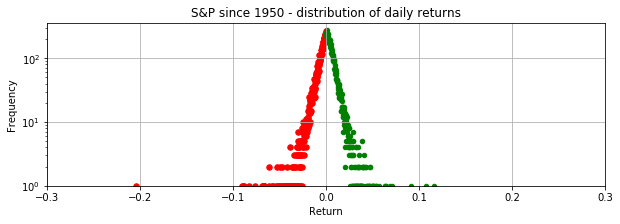

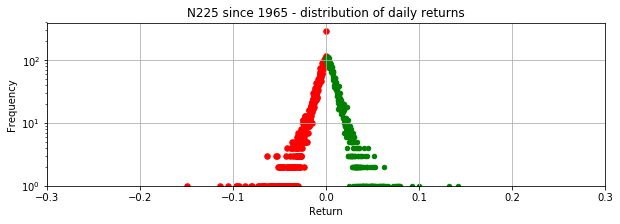

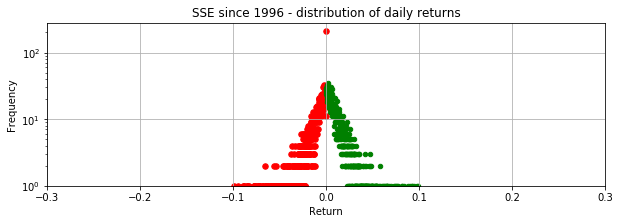

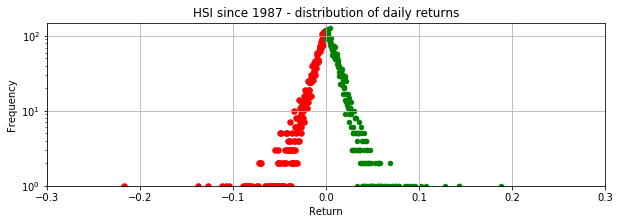

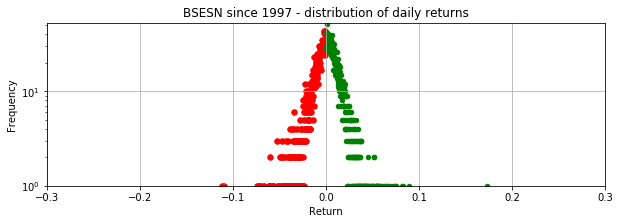

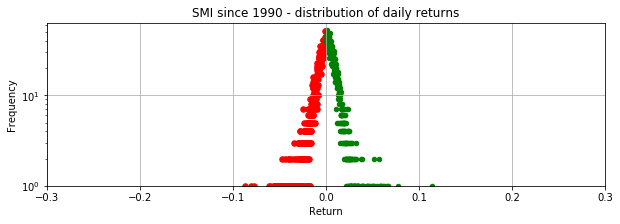

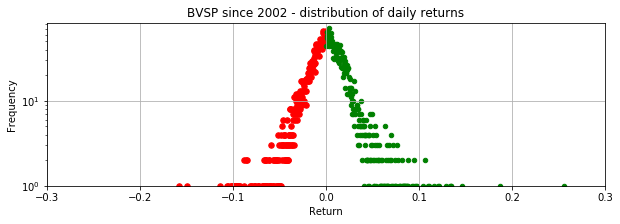

In [68]:
##### Plot log-distribution of daily returns
for ds, t in zip(datasets, plt_titles):
    max_return = max(abs(ds['ch']))
    m = round(max_return+0.01,2)
    bins = np.linspace(-m, m, 2000)
    d = {}
    for i in range(1, len(bins)+1):
        d[i] = bins[i-1]
    disc = np.digitize(x=ds['ch'], bins=bins)
    d1 = defaultdict(int)
    for i in disc:
        d1[d[i]] += 1
    df = pd.DataFrame(list(d1.items()))
    df.columns = ['return', 'n']
    df_neg = df[df['return']<0]
    df_neg = df_neg.sort_values(by='return', ascending=True).reset_index(drop=True)
    plt.scatter(df_neg['return'], df_neg['n'], s=30, color='red')
    plt.yscale('log')
    df_neg_reg = df_neg[df_neg['return']>-0.05]
    m, c = np.polyfit(df_neg_reg['return'], np.log(df_neg_reg['n']), 1)
    y_fit = np.exp(m*df_neg['return'] + c)
    plt.ylim(bottom=10**0)
    df_pos = df[df['return']>0]
    df_pos = df_pos.sort_values(by='return', ascending=False).reset_index(drop=True)
    plt.scatter(df_pos['return'], df_pos['n'], s=20, color='green')
    plt.yscale('log')
    df_pos_reg = df_pos[df_pos['return']<0.05]
    m, c = np.polyfit(df_pos_reg['return'], np.log(df_pos_reg['n']), 1)
    y_fit = np.exp(m*df_pos['return'] + c)
    plt.ylim(bottom=10**0)
    plt.xlim(-0.3, 0.3)
    plt.title(t + ' - distribution of daily returns')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
    plt.show()

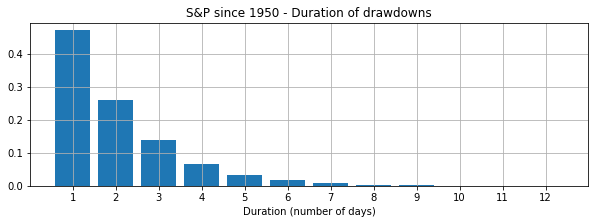

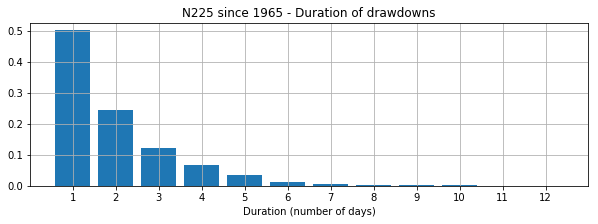

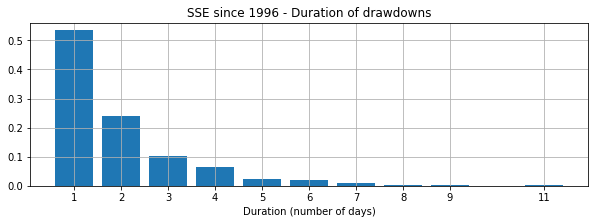

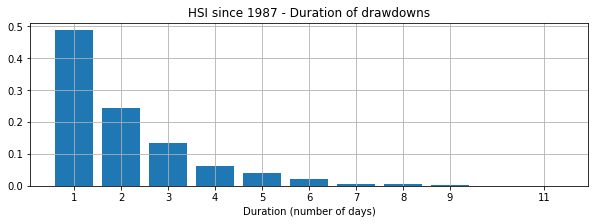

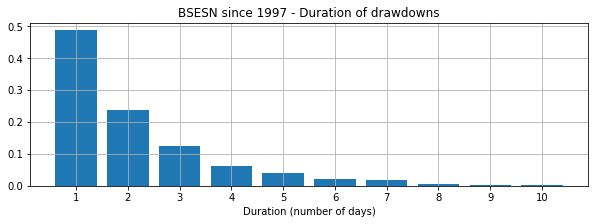

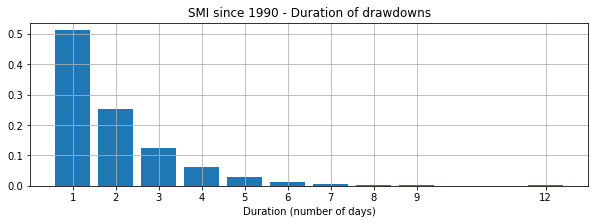

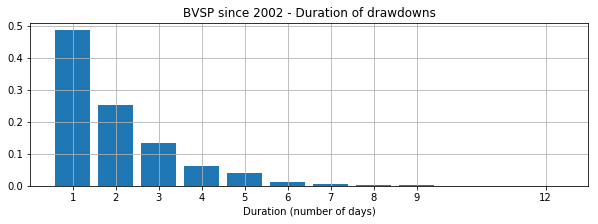

In [71]:
##### Drawdowns
dd_df = []
for ds in datasets:
    pmin_pmax = (ds['price'].diff(-1) > 0).astype(int).diff() #<- -1 indicates pmin, +1 indicates pmax
    pmax = pmin_pmax[pmin_pmax == 1]
    pmin = pmin_pmax[pmin_pmax == -1]
    if pmin.index[0] < pmax.index[0]:
        pmin = pmin.drop(pmin.index[0])
    if pmin.index[-1] < pmax.index[-1]:
        pmax = pmax.drop(pmax.index[-1])
    dd = (np.array(ds['price'][pmin.index]) - np.array(ds['price'][pmax.index])) \
        / np.array(ds['price'][pmax.index])
    dur = [np.busday_count(p1.date(), p2.date()) for p1, p2 in zip(pmax.index, pmin.index)]
    d = {'Date':pmax.index, 'drawdown':dd, 'd_start': pmax.index, 'd_end': pmin.index, \
         'duration': dur}    
    df_d = pd.DataFrame(d).set_index('Date')
    df_d.index = pd.to_datetime(df_d.index, format='%Y/%m/%d')
    df_d = df_d.sort_values(by='drawdown')
    df_d['rank'] = list(range(1,df_d.shape[0]+1))
    dd_df.append(df_d)

# Plot duration of drawdowns
l_dict_dd = []
for dd, t in zip(dd_df, plt_titles):
    max_dd = max(abs(dd['drawdown']))
    m = round(max_dd+0.01,2)
    bins = np.linspace(-m, m, 800)
    d = {}
    for i in range(1, len(bins)+1):
        d[i] = bins[i-1]
    disc = np.digitize(x=dd['drawdown'], bins=bins)
    d1 = defaultdict(int)
    for i in disc:
        d1[d[i]] += 1
    l_dict_dd.append(d1)
    plt.bar(x=dd['duration'].value_counts().index, height=dd['duration'].\
        value_counts()/dd['duration'].shape[0])
    plt.xticks(dd['duration'].value_counts().index)
    plt.title(t + ' - Duration of drawdowns')
    plt.xlabel('Duration (number of days)')
    plt.grid()
    plt.show()

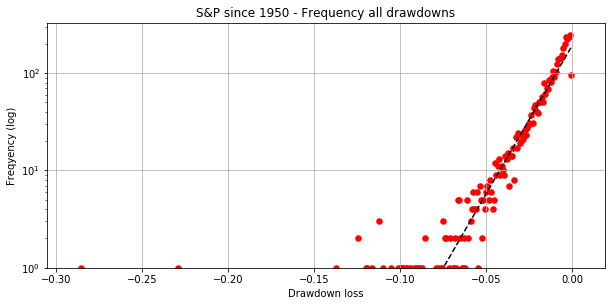

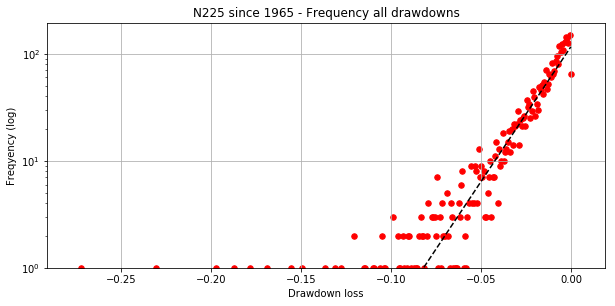

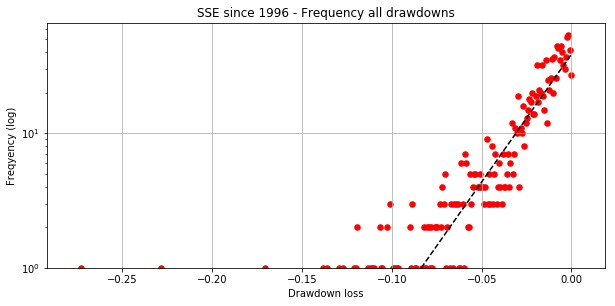

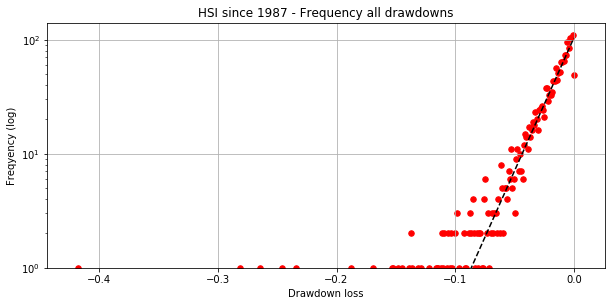

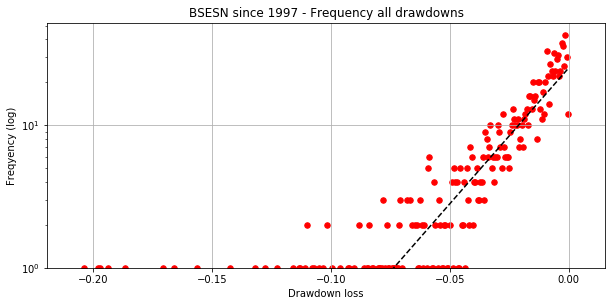

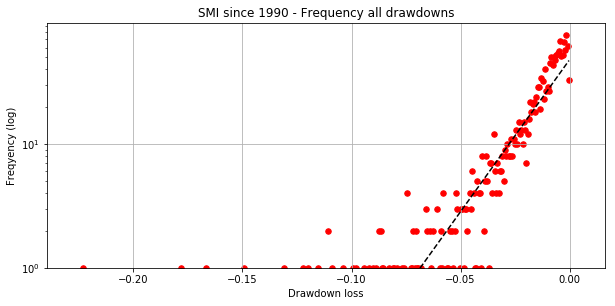

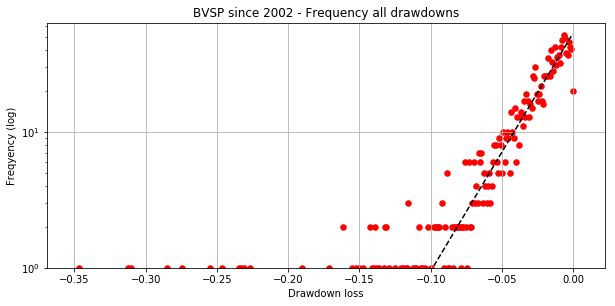

In [78]:
##### Plot frequency oof drawdowns
rcParams['figure.figsize'] = 10, 4.5
for d1, t in zip(l_dict_dd, plt_titles):
    df_d_bins = pd.DataFrame(list(d1.items()))
    df_d_bins.columns = ['drawdown', 'n']
    plt.scatter(df_d_bins['drawdown'], df_d_bins['n'], s=30, color='red')
    plt.yscale('log')
    df_d_bins_reg = df_d_bins[df_d_bins['drawdown']>-0.08]
    m, c = np.polyfit(df_d_bins_reg['drawdown'], np.log(df_d_bins_reg['n']), 1)
    y_fit = np.exp(m*df_d_bins['drawdown'] + c)
    plt.ylim(bottom=10**0)
    plt.plot(df_d_bins['drawdown'], y_fit, color='black', ls='dashed')
    plt.title(t + ' - Frequency all drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Freqyency (log)')
    plt.grid()
    plt.show()


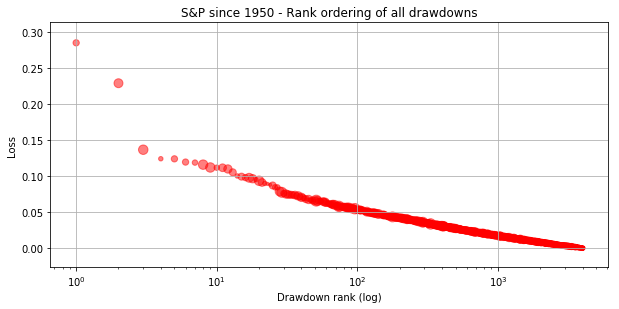

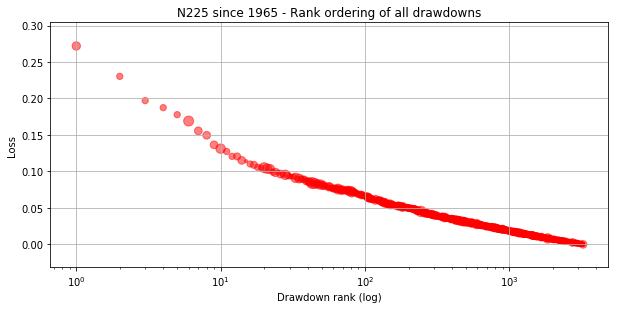

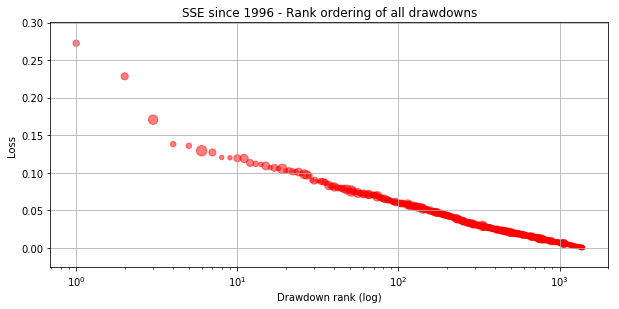

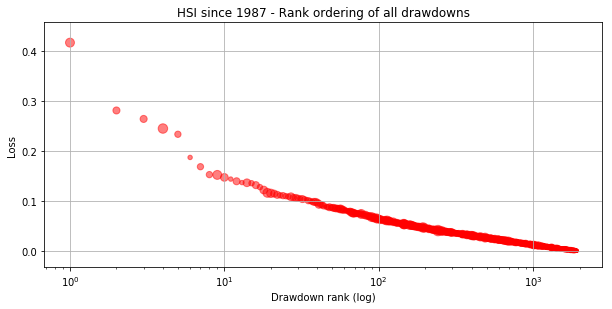

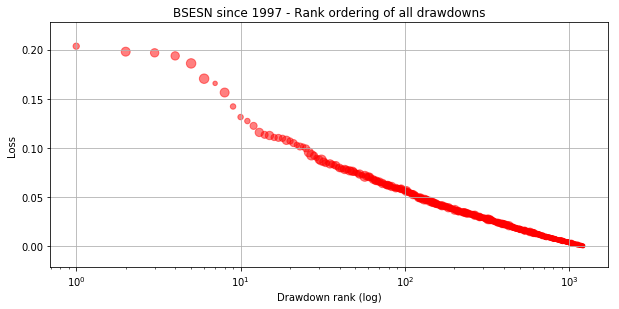

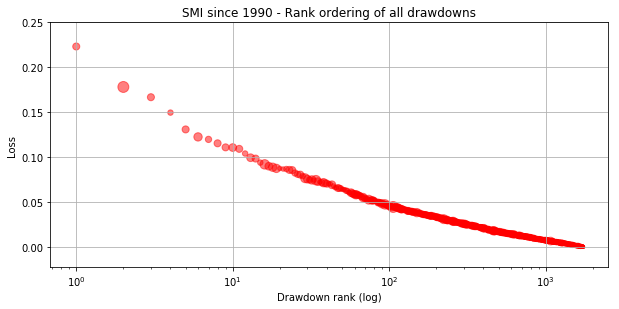

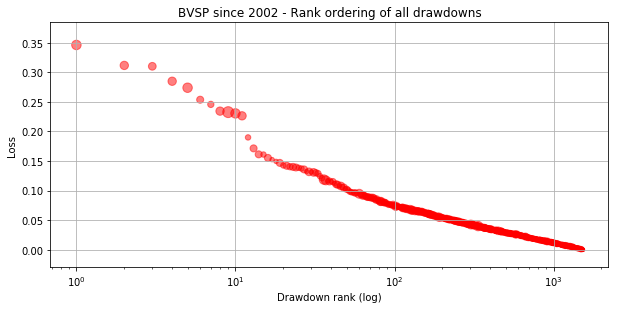

In [79]:
##### Drawdown by rank
for dd, t in zip(dd_df, plt_titles):
    plt.scatter(dd['rank'], abs(dd['drawdown']), s=10*dd['duration'], alpha=0.5,\
                color='red')
    plt.xscale('log')
    plt.title(t + ' - Rank ordering of all drawdowns')
    plt.xlabel('Drawdown rank (log)')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

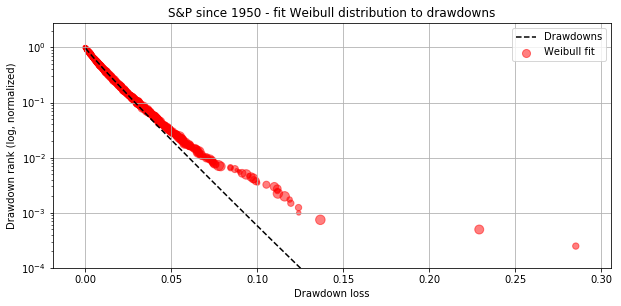

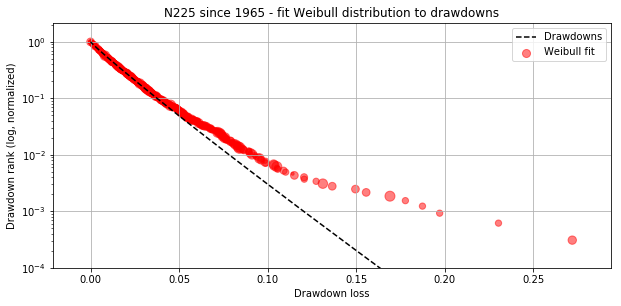

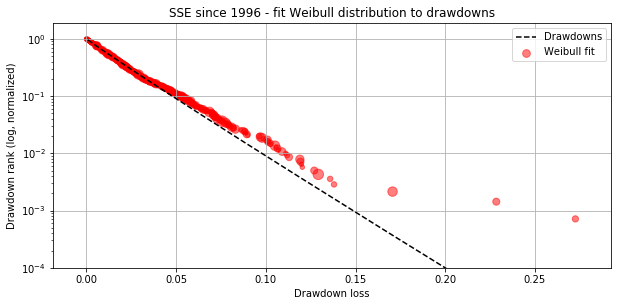

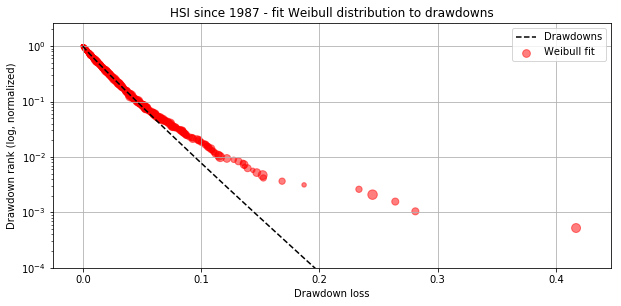

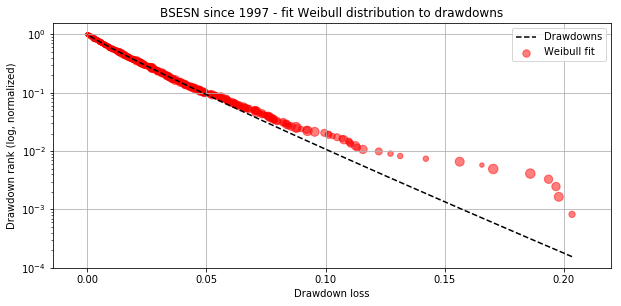

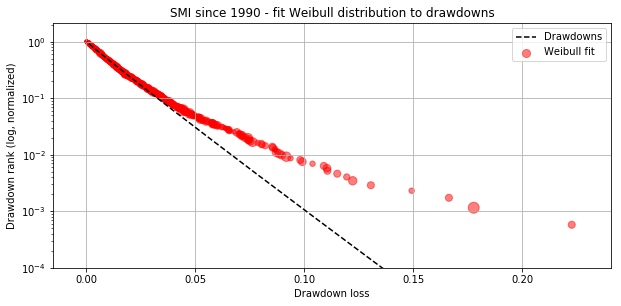

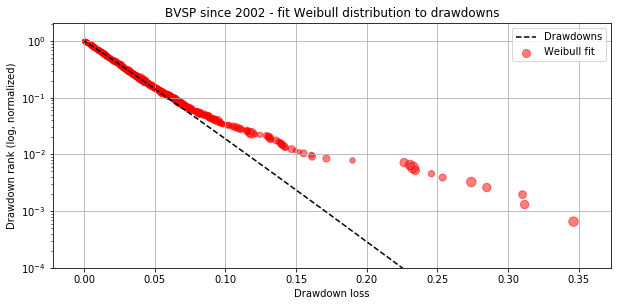

In [80]:
##### Fit Weibull exponential function to drawdowns by rank
def weibull(x, chi, z):
    return np.exp(-abs(x/chi)**z)

for dd, t in zip(dd_df, plt_titles):
    x = dd['drawdown']
    y = dd['rank']/dd['rank'].max()
    init_vals = [0.9, 0.015]  # for [z, chi]
    best_vals, covar = curve_fit(weibull, abs(x), y, p0=init_vals)
    chi = best_vals[0]
    z = best_vals[1]
    plt.scatter(abs(x), y, s=10*dd['duration'], alpha=0.5, color='red')
    y_fit = [weibull(abs(xi), chi, z) for xi in x]
    plt.plot(abs(x), y_fit, color='black', ls='dashed')
    plt.yscale('log')
    plt.ylim(bottom=10**-4)
    plt.legend(['Drawdowns', 'Weibull fit'])
    plt.title(t + ' - fit Weibull distribution to drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Drawdown rank (log, normalized)')
    plt.grid()
    plt.show()

### 3. Identify Crashes
- First methodology: crashes as the 99.5% empirical quantile of the drawdowns (as suggested by Jacobsson, E., Stockholm University, in 'How to predict crashes in financial markets with the Log-Periodic Power Law', 2009).
- Second methodology: Crashes as outliers of the fitted Weibull exponential model(as suggested by Johansen, A. and Sornette, D. in 'Large Stock Market Price Drawdowns Are Outliers', 2001). This methodology requires manual identification of crashes based on the Weibull plots.

#### 3.1 Crashes according to Jaccobsen

In [82]:
##### 2.1 Emilie Jacobsen, Stockholm University: empirical quantile: 99.5%
crash_thresholds = []
for dd in dd_df:
    ct = dd['drawdown'].iloc[round(dd.shape[0] * .005)]
    crash_thresholds.append(ct)

crashes = []
for df, dd, ct in zip(datasets, dd_df, crash_thresholds):
    df_d = dd.reindex(df.index).fillna(0)
    df_d = df_d.sort_values(by='Date')
    df_c = df_d[df_d['drawdown'] < ct]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'duration', 'rank']
    crashes.append(df_c)
df_combined = []  
for i in range(len(datasets)):
    df_combined.append(pd.concat([datasets[i], dd_df[i]], axis=1).fillna(0))

for c, t in zip(crashes, plt_titles):
    c['crash_st'] = c['crash_st'].dt.date
    c['crash_end'] = c['crash_end'].dt.date
    c['duration'] = c['duration'].astype(int)
    c['rank'] = c['rank'].astype(int)
    print(t + ' - all crashes (99.5% drawdown quantile):')
    display(c)
    print('\n')

S&P since 1950 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1962-05-15,-0.136724,1962-05-15,1962-05-28,9,3
1974-08-07,-0.097762,1974-08-07,1974-08-19,8,17
1974-09-20,-0.112062,1974-09-20,1974-10-03,9,9
1974-11-11,-0.096474,1974-11-11,1974-11-20,7,18
1980-11-28,-0.093652,1980-11-28,1980-12-11,9,20
1987-10-13,-0.285133,1987-10-13,1987-10-19,4,1
1987-10-21,-0.118856,1987-10-21,1987-10-26,3,7
1997-10-21,-0.098007,1997-10-21,1997-10-27,4,16
1998-08-25,-0.124052,1998-08-25,1998-08-31,4,5




N225 since 1965 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1970-04-24,-0.127345,1970-04-24,1970-04-30,4,11
1971-08-13,-0.197097,1971-08-13,1971-08-19,4,3
1973-11-30,-0.131144,1973-11-30,1973-12-13,9,10
1974-09-25,-0.169037,1974-09-25,1974-10-09,10,6
1987-10-14,-0.177748,1987-10-14,1987-10-20,4,5
1990-03-26,-0.120552,1990-03-26,1990-04-02,5,13
1990-08-15,-0.155609,1990-08-15,1990-08-23,6,7
1990-09-21,-0.149550,1990-09-21,1990-10-01,6,8
1997-01-06,-0.110169,1997-01-06,1997-01-10,4,16




SSE since 1996 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1996-12-11,-0.272568,1996-12-11,1996-12-17,4,1
2008-06-02,-0.170638,2008-06-02,2008-06-13,9,3
2008-09-25,-0.129240,2008-09-25,2008-10-10,11,6
2008-10-20,-0.126978,2008-10-20,2008-10-27,5,7
2015-06-24,-0.135842,2015-06-24,2015-06-29,3,5
2015-06-30,-0.138012,2015-06-30,2015-07-03,3,4
2015-08-19,-0.228465,2015-08-19,2015-08-26,5,2




HSI since 1987 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1987-10-14,-0.416907,1987-10-14,1987-10-26,8,1
1989-05-29,-0.264112,1989-05-29,1989-06-05,5,3
1992-11-27,-0.168457,1992-11-27,1992-12-03,4,7
1997-10-17,-0.233417,1997-10-17,1997-10-23,4,5
1997-10-24,-0.187037,1997-10-24,1997-10-28,2,6
1997-12-30,-0.244914,1997-12-30,1998-01-12,9,4
2008-09-08,-0.152052,2008-09-08,2008-09-18,8,9
2008-10-02,-0.152620,2008-10-02,2008-10-08,4,8
2008-10-20,-0.281092,2008-10-20,2008-10-27,5,2




BSESN since 1997 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2000-04-11,-0.185957,2000-04-11,2000-04-24,9,5
2001-09-04,-0.170386,2001-09-04,2001-09-17,9,6
2008-01-11,-0.196736,2008-01-11,2008-01-22,7,3
2008-10-01,-0.193619,2008-10-01,2008-10-10,7,4
2008-10-21,-0.203478,2008-10-21,2008-10-27,4,1
2008-11-10,-0.197904,2008-11-10,2008-11-20,8,2




SMI since 1990 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1998-09-28,-0.166382,1998-09-28,1998-10-05,5,3
2001-09-17,-0.119478,2001-09-17,2001-09-21,4,7
2002-07-17,-0.130555,2002-07-17,2002-07-24,5,5
2003-03-03,-0.122230,2003-03-03,2003-03-12,7,6
2008-01-14,-0.110609,2008-01-14,2008-01-21,5,9
2008-10-03,-0.222768,2008-10-03,2008-10-10,5,1
2008-10-20,-0.115113,2008-10-20,2008-10-27,5,8
2011-07-21,-0.177769,2011-07-21,2011-08-08,12,2
2015-01-13,-0.149264,2015-01-13,2015-01-16,3,4




BVSP since 2002 - all crashes (99.5% drawdown quantile):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1995-02-03,-0.273958,1995-02-03,1995-02-16,9,5
1995-02-24,-0.346266,1995-02-24,1995-03-09,9,1
1997-10-21,-0.245774,1997-10-21,1997-10-27,4,7
1998-08-18,-0.234409,1998-08-18,1998-08-27,7,8
1998-09-01,-0.311696,1998-09-01,1998-09-10,7,2
1999-01-06,-0.310190,1999-01-06,1999-01-14,6,3
2008-10-01,-0.284925,2008-10-01,2008-10-10,7,4
2008-10-20,-0.253695,2008-10-20,2008-10-27,5,6


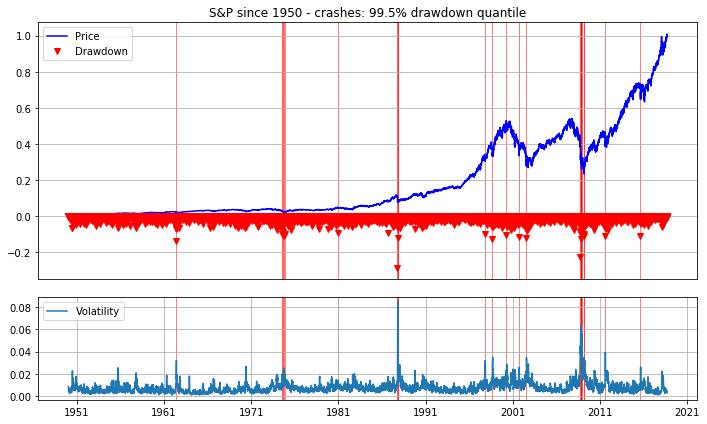

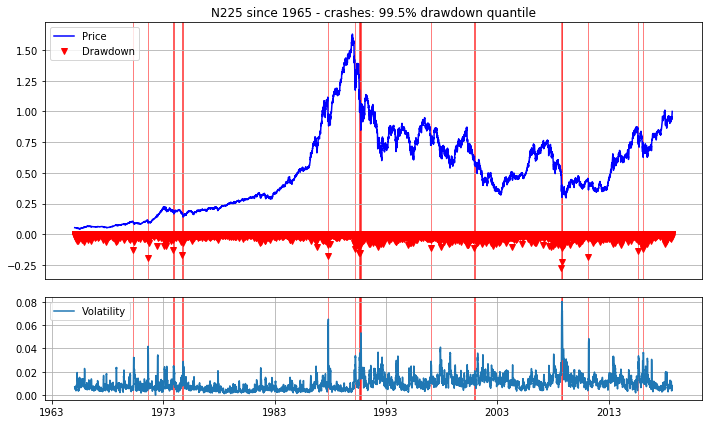

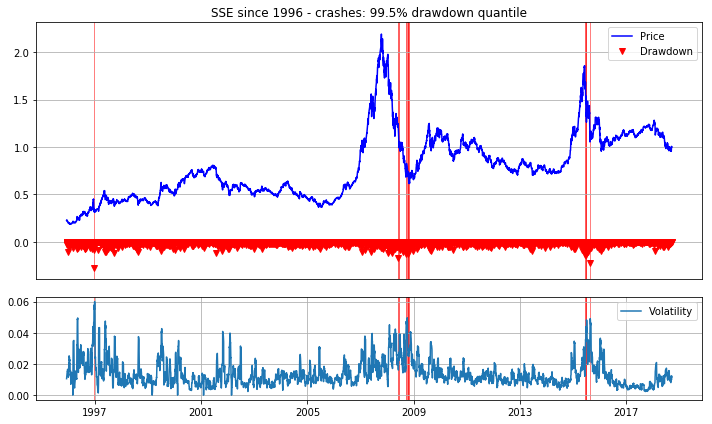

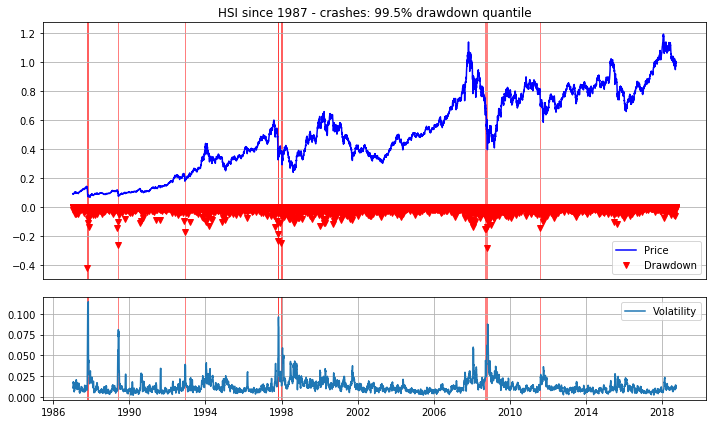

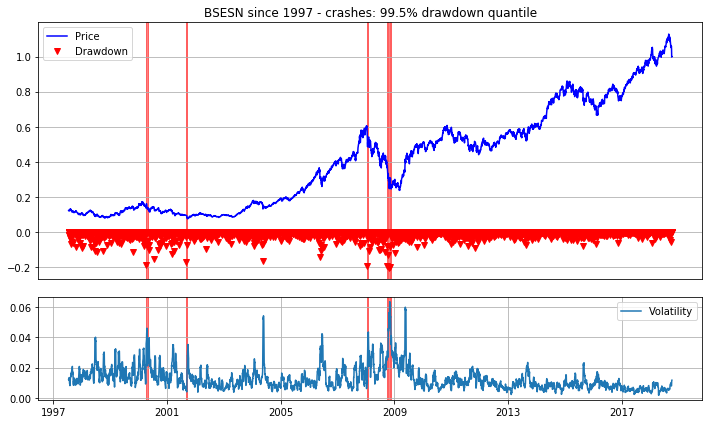

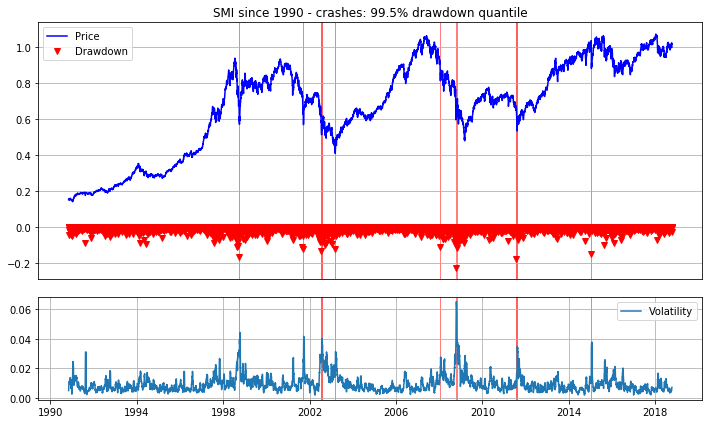

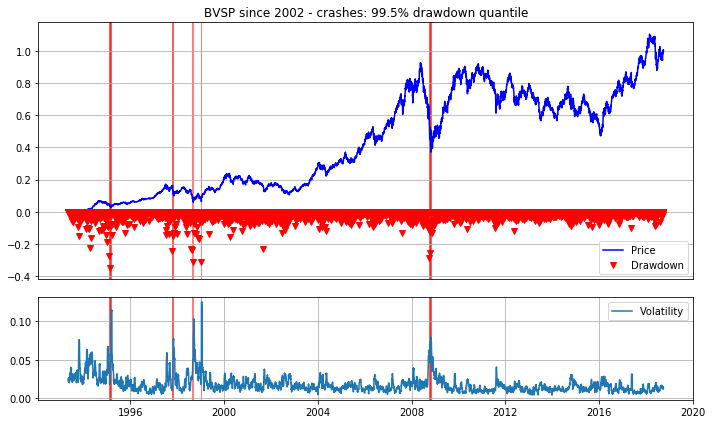

In [84]:
##### 2.1 Plot crashes in time series
rcParams['figure.figsize'] = 10, 6
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i] + ' - crashes: 99.5% drawdown quantile')
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()


#### 2.2 Crashes according to Johansen and Sornette

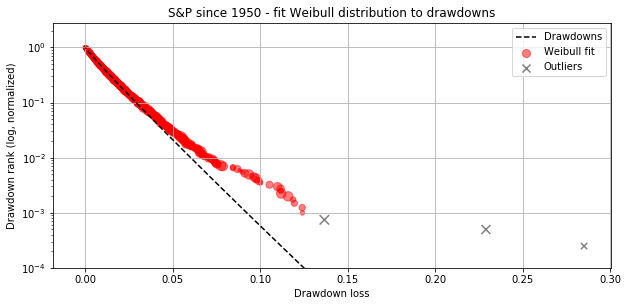

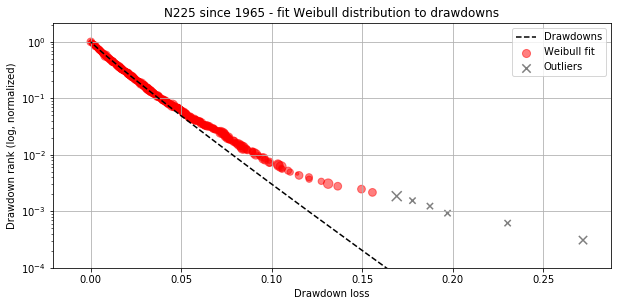

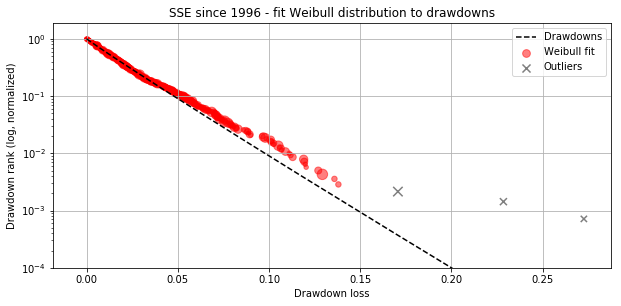

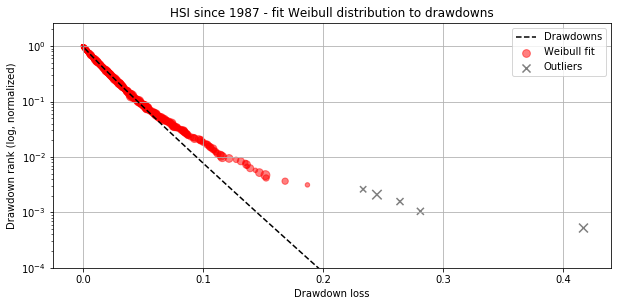

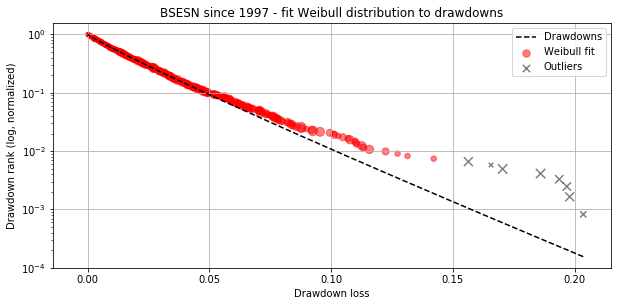

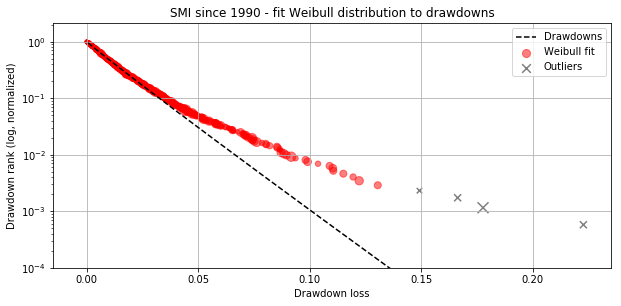

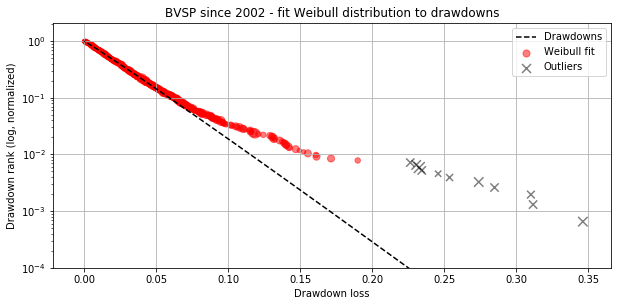

In [86]:
n_crashes = [3, 6, 3, 5, 8, 4, 11]  # <-- number of crashes manually identified based on outliers in Weibul plots below
rcParams['figure.figsize'] = 10, 4.5
for dd, t, n in zip(dd_df, plt_titles, n_crashes):
    x = dd['drawdown']
    y = dd['rank']/dd['rank'].max()
    init_vals = [0.9, 0.015]  # for [z, chi]
    best_vals, covar = curve_fit(weibull, abs(x), y, p0=init_vals)
    chi = best_vals[0]
    z = best_vals[1]
    plt.scatter(abs(x[n:]), y[n:], s=10*dd['duration'][n:], alpha=0.5, color='red')
    plt.scatter(abs(x[:n]), y[:n], s=10*dd['duration'][:n], alpha=0.5, color='black', marker='x')
    y_fit = [weibull(abs(xi), chi, z) for xi in x]
    plt.plot(abs(x), y_fit, color='black', ls='dashed')
    plt.yscale('log')
    plt.ylim(bottom=10**-4)
    plt.legend(['Drawdowns', 'Weibull fit', 'Outliers'])
    plt.title(t + ' - fit Weibull distribution to drawdowns')
    plt.xlabel('Drawdown loss')
    plt.ylabel('Drawdown rank (log, normalized)')
    plt.grid()
    plt.show()

In [87]:
crashes = []
for df, dd, r in zip(datasets, dd_df, n_crashes):
    df_c = dd[dd['rank'] <= r]
    df_c.columns = ['drawdown', 'crash_st', 'crash_end', 'duration', 'rank']
    crashes.append(df_c)

for c, t in zip(crashes, plt_titles):
    c['crash_st'] = c['crash_st'].dt.date
    c['crash_end'] = c['crash_end'].dt.date
    c['duration'] = c['duration'].astype(int)
    c['rank'] = c['rank'].astype(int)
    print(t + ' - all crashes (Weibull outliers):')
    display(c)
    print('\n')

S&P since 1950 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1987-10-13,-0.285133,1987-10-13,1987-10-19,4,1
2008-09-30,-0.229037,2008-09-30,2008-10-10,8,2
1962-05-15,-0.136724,1962-05-15,1962-05-28,9,3




N225 since 1965 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2008-10-01,-0.271970,2008-10-01,2008-10-10,7,1
2008-10-21,-0.230313,2008-10-21,2008-10-27,4,2
1971-08-13,-0.197097,1971-08-13,1971-08-19,4,3
2011-03-09,-0.187388,2011-03-09,2011-03-15,4,4
1987-10-14,-0.177748,1987-10-14,1987-10-20,4,5
1974-09-25,-0.169037,1974-09-25,1974-10-09,10,6




SSE since 1996 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1996-12-11,-0.272568,1996-12-11,1996-12-17,4,1
2015-08-19,-0.228465,2015-08-19,2015-08-26,5,2
2008-06-02,-0.170638,2008-06-02,2008-06-13,9,3




HSI since 1987 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1987-10-14,-0.416907,1987-10-14,1987-10-26,8,1
2008-10-20,-0.281092,2008-10-20,2008-10-27,5,2
1989-05-29,-0.264112,1989-05-29,1989-06-05,5,3
1997-12-30,-0.244914,1997-12-30,1998-01-12,9,4
1997-10-17,-0.233417,1997-10-17,1997-10-23,4,5




BSESN since 1997 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2008-10-21,-0.203478,2008-10-21,2008-10-27,4,1
2008-11-10,-0.197904,2008-11-10,2008-11-20,8,2
2008-01-11,-0.196736,2008-01-11,2008-01-22,7,3
2008-10-01,-0.193619,2008-10-01,2008-10-10,7,4
2000-04-11,-0.185957,2000-04-11,2000-04-24,9,5
2001-09-04,-0.170386,2001-09-04,2001-09-17,9,6
2004-05-13,-0.165629,2004-05-13,2004-05-17,2,7
2000-07-12,-0.156305,2000-07-12,2000-07-24,8,8




SMI since 1990 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
2008-10-03,-0.222768,2008-10-03,2008-10-10,5,1
2011-07-21,-0.177769,2011-07-21,2011-08-08,12,2
1998-09-28,-0.166382,1998-09-28,1998-10-05,5,3
2015-01-13,-0.149264,2015-01-13,2015-01-16,3,4




BVSP since 2002 - all crashes (Weibull outliers):


,drawdown,crash_st,crash_end,duration,rank
Date,,,,,
1995-02-24,-0.346266,1995-02-24,1995-03-09,9,1
1998-09-01,-0.311696,1998-09-01,1998-09-10,7,2
1999-01-06,-0.310190,1999-01-06,1999-01-14,6,3
2008-10-01,-0.284925,2008-10-01,2008-10-10,7,4
1995-02-03,-0.273958,1995-02-03,1995-02-16,9,5
2008-10-20,-0.253695,2008-10-20,2008-10-27,5,6
1997-10-21,-0.245774,1997-10-21,1997-10-27,4,7
1998-08-18,-0.234409,1998-08-18,1998-08-27,7,8
2001-08-29,-0.232699,2001-08-29,2001-09-14,12,9


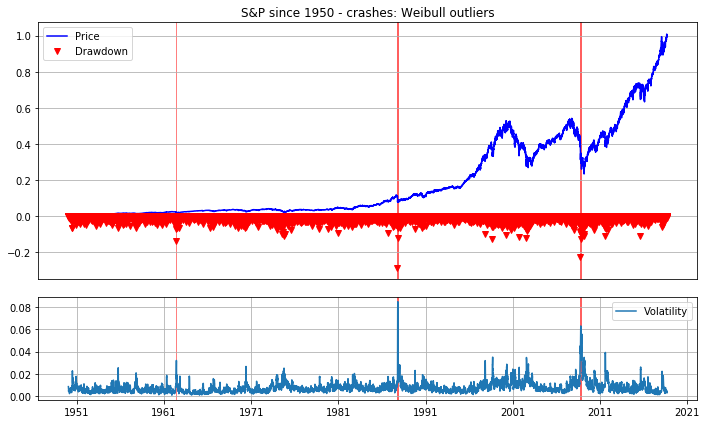

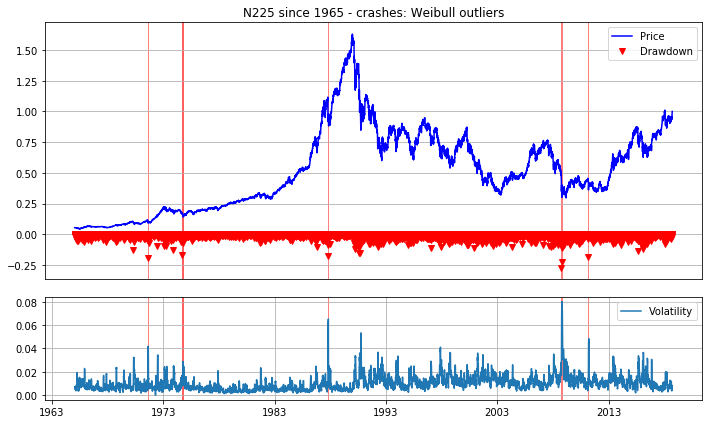

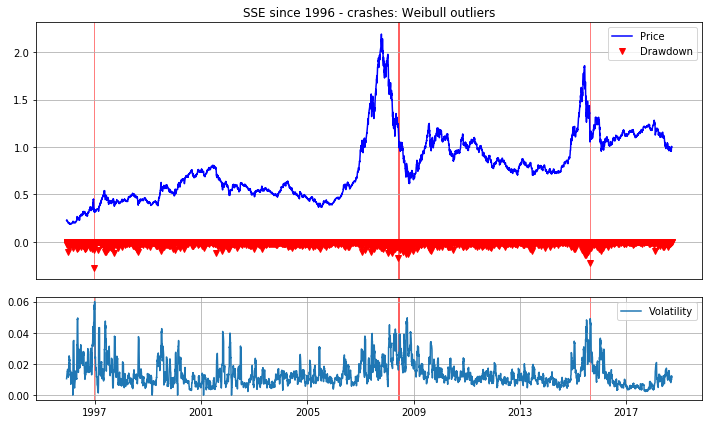

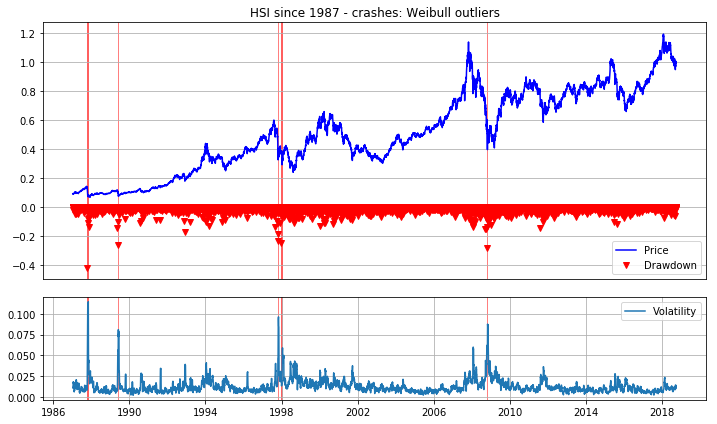

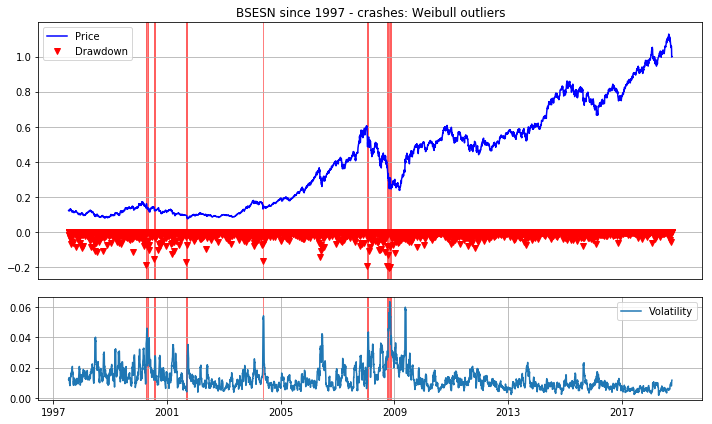

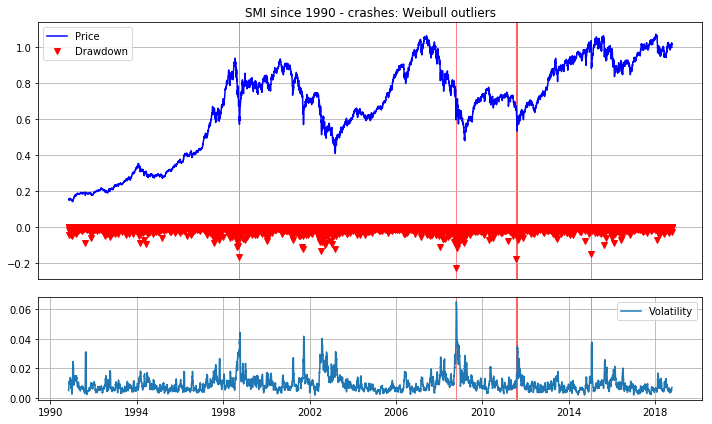

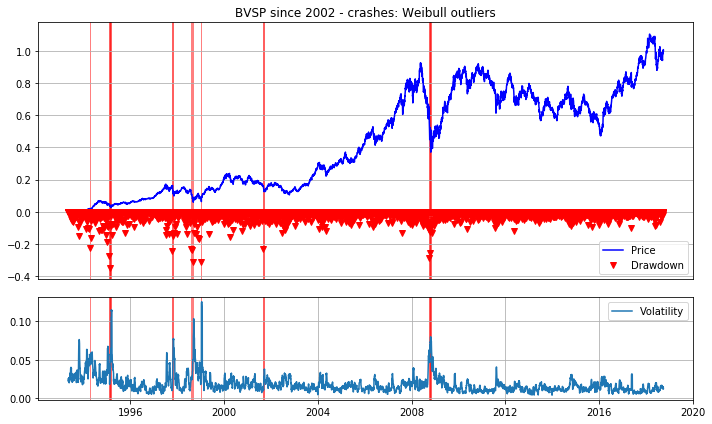

In [89]:
##### 2.2 Plot crashes in time series
rcParams['figure.figsize'] = 10, 6
gs = gridspec.GridSpec(2, 1, height_ratios=[2.5, 1]) 
for i in range(len(df_combined)):
    plt.subplot(gs[0])
    plt.plot(df_combined[i]['norm'], color='blue')
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.plot(df_combined[i]['drawdown'], color='red', marker='v',linestyle='')
    plt.title(plt_titles[i] + ' - crashes: Weibull outliers')
    plt.grid()
    plt.xticks([])
    plt.legend(['Price', 'Drawdown'])
    plt.subplot(gs[1])
    plt.plot(df_combined[i]['vol'])
    [plt.axvspan(x1, x2, alpha=0.5, color='red') for x1, x2 in zip(crashes[i]['crash_st'], \
         crashes[i]['crash_end'])]
    plt.legend(['Volatility'])
    plt.grid()
    plt.tight_layout()
    plt.show()